In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

In [10]:
# Rk4 algorithm
def rk4_(t, u, v, dt, f, g, omega, func):
    k1 = dt * f(u, v)
    l1 = dt * g(t, u, v, omega, func)

    k2 = dt * f(u + 0.5 * k1, v + 0.5 * l1)
    l2 = dt * g(t + 0.5 * dt, u + 0.5 * k1, v + 0.5 * l1, omega, func)

    k3 = dt * f(u + 0.5 * k2, v + 0.5 * l2)
    l3 = dt * g(t + 0.5 * dt, u + 0.5 * k2, v + 0.5 * l2, omega, func)

    k4 = dt * f(u + k3, v + l3)
    l4 = dt * g(t + dt, u + k3, v + l3, omega, func)

    u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
    v_next = v + (l1 + 2*l2 + 2*l3 + l4) / 6

    return u_next, v_next

def rk4(n, u0, v0, dt, fu, fv, omega, func):

    t = [0]
    u = [u0]
    v = [v0]

    for i in range(n):

        u_, v_ = rk4_(t[-1], u[-1], v[-1], dt, fu, fv, omega, func)

        t.append(t[-1]+dt)
        u.append(u_)
        v.append(v_)

    return t, u, v

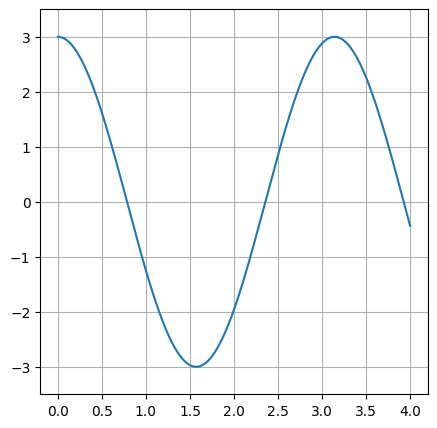

In [101]:
def func(t, u, v):
    return 0
    return -0.5*np.sin(t)

def fu(u, v):

    return v

def fv(t, u, v, omega, func):

    f = func(t, u, v)

    return f - omega**2 * u

u0 = 3
v0 = 0
omega = 2

dt = 1e-2

data = []

# Primeira trajetória
u0 = 3
v0 = 0
t1, u1, v1 = rk4(400, u0, v0, dt, fu, fv, omega, func)
t1 = torch.tensor(t1, dtype=torch.float32)
u1 = torch.tensor(u1, dtype=torch.float32)
v1 = torch.tensor(v1, dtype=torch.float32)
data.append([t1, u1, v1, u0, v0])

# Segunda trajetória
u0 = 1
v0 = 3
t2, u2, v2 = rk4(400, u0, v0, dt, fu, fv, omega, func)
t2 = torch.tensor(t2, dtype=torch.float32)
u2 = torch.tensor(u2, dtype=torch.float32)
v2 = torch.tensor(v2, dtype=torch.float32)
data.append([t2, u2, v2, u0, v0])

# Terceira trajetória
u0 = -3
v0 = -1
t3, u3, v3 = rk4(400, u0, v0, dt, fu, fv, omega, func)
t3 = torch.tensor(t3, dtype=torch.float32)
u3 = torch.tensor(u3, dtype=torch.float32)
v3 = torch.tensor(v3, dtype=torch.float32)
data.append([t3, u3, v3, u0, v0])

plt.figure(figsize=(5,5))
plt.ylim(-3.5,3.5)
plt.plot(t1, u1)
plt.grid()
plt.show()


In [50]:
print(data[0][0][1])

tensor(0.0100)


In [97]:
X = []
Y = []


for j in range(len(data)):

    t = data[j][0]
    u = data[j][1]
    v = data[j][2]
    u0 = data[j][3]
    v0 = data[j][4]

    for i in range(3,len(u)-3):
        X.append([t[i], u[i-1], u[i-2], u[i-3], v[i-1], v[i-2], v[i-3], u0, v0])
        Y.append([u[i], v[i]])

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

In [52]:
print(X.shape)

torch.Size([1185, 9])


In [53]:
class ResidualNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7+2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        # Predizer apenas o incremento, não o valor absoluto
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1)) + x1  # Residual connection
        delta = self.fc3(x2)
        
        # Adicionar incremento aos valores anteriores
        u_prev = x[:, 1]  # u[i-1]
        v_prev = x[:, 4]  # v[i-1]
        
        return torch.stack([u_prev + delta[:, 0], v_prev + delta[:, 1]], dim=1)

In [54]:
model = ResidualNN()
criterion = nn.MSELoss()

In [55]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [56]:
for epoch in range(20000):
    pred = model(X).squeeze()
    loss = criterion(pred, Y)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


#print("Learned weight matrix:", model.fc.weight.data)

Epoch 0, Loss: 0.5766558647155762
Epoch 1000, Loss: 0.0012422790750861168
Epoch 2000, Loss: 0.00029146496672183275
Epoch 3000, Loss: 0.00013372066314332187
Epoch 4000, Loss: 7.465318049071357e-05
Epoch 5000, Loss: 4.5457818487193435e-05
Epoch 6000, Loss: 2.8615429982892238e-05
Epoch 7000, Loss: 1.8420181731926277e-05
Epoch 8000, Loss: 1.1862395695061423e-05
Epoch 9000, Loss: 7.3752230491663795e-06
Epoch 10000, Loss: 4.455228463484673e-06
Epoch 11000, Loss: 2.7080541258328594e-06
Epoch 12000, Loss: 1.9035337572859135e-06
Epoch 13000, Loss: 1.4810185575697687e-06
Epoch 14000, Loss: 1.23106985938648e-06
Epoch 15000, Loss: 1.0569604000920663e-06
Epoch 16000, Loss: 9.156124178844038e-07
Epoch 17000, Loss: 8.242918738687877e-07
Epoch 18000, Loss: 1.0626285984471906e-06
Epoch 19000, Loss: 7.109055104592699e-07


In [57]:
print(pred[0,1])

tensor(-0.3606, grad_fn=<SelectBackward0>)


In [99]:
trajectory = 1

u = data[trajectory][1]
v = data[trajectory][2]
t = data[trajectory][0]
u0 = data[trajectory][3]
v0 = data[trajectory][4]

# Predict series starting from initial conditions
u_preds = [u[0], u[1], u[2]]  # Ordem temporal correta
v_preds = [v[0], v[1], v[2]]

X_preds = []
Y_preds = []

# Começar do tempo inicial com incremento correto
current_time = t[3]  # Próximo tempo após os 3 valores iniciais
print(t[3])

N = 390  # Número de predições a serem feitas

for i in range(N):  # Predizer mais pontos para visualizar melhor
    # Criar input com últimos 3 valores em ordem temporal correta
    input_ = [t[i+3], u_preds[-1], u_preds[-2], u_preds[-3], 
              v_preds[-1], v_preds[-2], v_preds[-3], u0, v0]
    
    input_tensor = torch.tensor(input_, dtype=torch.float32).unsqueeze(0)
    pred = model(input_tensor)
    
    # Adicionar no final (ordem temporal correta)
    u_preds.append(pred[0][0].item())
    v_preds.append(pred[0][1].item())
    
    X_preds.append(input_)
    Y_preds.append([u_preds[-1], v_preds[-1]])
    
    #current_time += dt  # Incremento consistente com o treinamento

X_preds = torch.tensor(X_preds, dtype=torch.float32)
Y_preds = torch.tensor(Y_preds, dtype=torch.float32)
u_preds = torch.tensor(u_preds, dtype=torch.float32)
v_preds = torch.tensor(v_preds, dtype=torch.float32)

tensor(15.6303)


In [89]:
print(X_preds[:,0])

tensor([7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301, 7.8301,
        7.8301, 7.8301, 7.8301, 7.8301, 

In [90]:
print(X_preds.shape)
print(Y_preds.shape)
print(Y_preds[2])

torch.Size([390, 9])
torch.Size([390, 2])
tensor([ 3.0235, -0.4699])


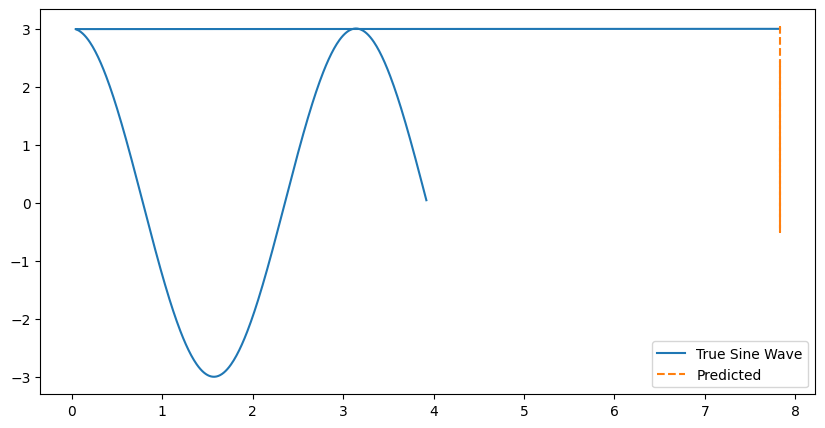

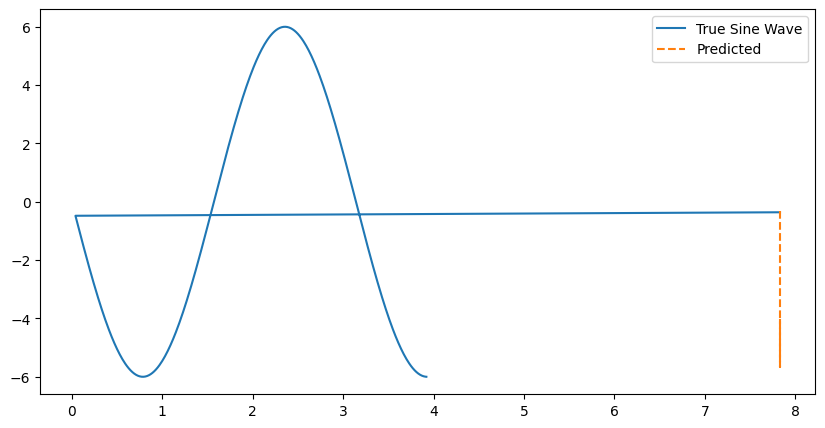

In [91]:
u = data[trajectory][1]
v = data[trajectory][2]
t = data[trajectory][0]

# Ajustar os índices para que os eixos x coincidam
start_idx = 3  # Começar do mesmo ponto das predições

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t[start_idx:start_idx+N].numpy(), u[start_idx:start_idx+N].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,0].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t[start_idx:start_idx+N].numpy(), v[start_idx:start_idx+N].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,1].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()

In [74]:
print(X_preds[:,0])

tensor([3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300, 3.9300,
        3.9300, 3.9300, 3.9300, 3.9300, 

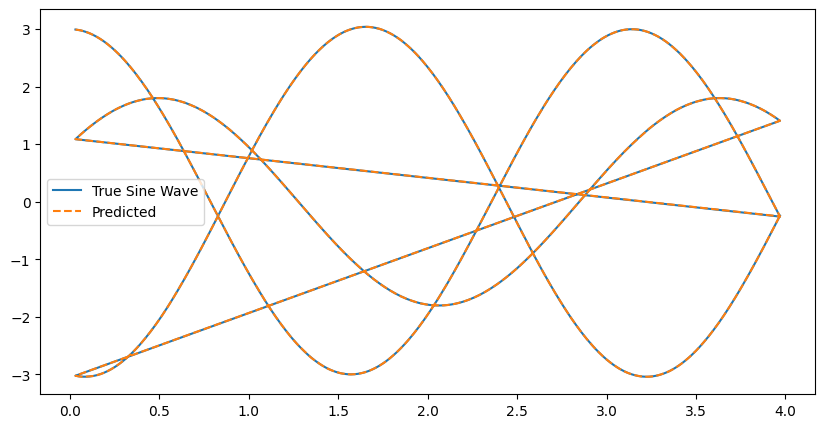

In [71]:

# Predict series starting from x[5]

pred = model(X)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(X[:,0], Y[:,0].numpy(), label='True Sine Wave')
plt.plot(X[:,0], pred[:,0].detach().numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()